In [1]:
import findspark
findspark.init()

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum
from functools import reduce
import pandas as pd
from pyspark.sql.functions import col, expr, percentile_approx
from pyspark.sql.functions import to_timestamp
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import to_date
from pyspark.sql.functions import avg
import matplotlib.pyplot as plt
import os
from pymongo import MongoClient
from datetime import datetime
import numpy as np

# Start Spark session
spark = SparkSession.builder \
    .appName("OPSData") \
    .config("spark.mongodb.input.uri", "mongodb://localhost/opsd.power") \
    .config("spark.mongodb.output.uri", "mongodb://localhost/opsd.power") \
    .getOrCreate()

# Optional: reduce log noise
spark.sparkContext.setLogLevel("WARN")


In [2]:
base_path = os.path.expanduser("~/Documents/SparkNotebooks/opsd")
file_name = "time_series_60min_singleindex.csv"

file_path = os.path.join(base_path, file_name)

df = spark.read.csv(file_path, header=True, inferSchema=True)

# Dataset is really wide and can't be viewed properly in notebooks
df.show(5)


+-------------------+-------------------+----------------------------------+------------------------------------+------------------+--------------------------+---------------------------------+----------------------------------+------------------------------------+--------------------------+-------------------------+----------------------------------+---------------------------------+----------------------------------+------------------------------------+--------------------------+---------------------------------+----------------------------------+------------------------------------+-----------------+--------------------------+------------------------+---------------------------------+----------------------------------+------------------------------------+---------------------------------+----------------------------------+------------------------------------+--------------------------+---------------------------------+----------------------------------+------------------------------

In [3]:
df.printSchema()         # See all the columns and data types

root
 |-- utc_timestamp: timestamp (nullable = true)
 |-- cet_cest_timestamp: timestamp (nullable = true)
 |-- AT_load_actual_entsoe_transparency: double (nullable = true)
 |-- AT_load_forecast_entsoe_transparency: double (nullable = true)
 |-- AT_price_day_ahead: double (nullable = true)
 |-- AT_solar_generation_actual: double (nullable = true)
 |-- AT_wind_onshore_generation_actual: double (nullable = true)
 |-- BE_load_actual_entsoe_transparency: double (nullable = true)
 |-- BE_load_forecast_entsoe_transparency: double (nullable = true)
 |-- BE_solar_generation_actual: double (nullable = true)
 |-- BE_wind_generation_actual: double (nullable = true)
 |-- BE_wind_offshore_generation_actual: double (nullable = true)
 |-- BE_wind_onshore_generation_actual: double (nullable = true)
 |-- BG_load_actual_entsoe_transparency: double (nullable = true)
 |-- BG_load_forecast_entsoe_transparency: double (nullable = true)
 |-- BG_solar_generation_actual: double (nullable = true)
 |-- BG_wind_on

In [4]:
df.columns               # Get list of column names

['utc_timestamp',
 'cet_cest_timestamp',
 'AT_load_actual_entsoe_transparency',
 'AT_load_forecast_entsoe_transparency',
 'AT_price_day_ahead',
 'AT_solar_generation_actual',
 'AT_wind_onshore_generation_actual',
 'BE_load_actual_entsoe_transparency',
 'BE_load_forecast_entsoe_transparency',
 'BE_solar_generation_actual',
 'BE_wind_generation_actual',
 'BE_wind_offshore_generation_actual',
 'BE_wind_onshore_generation_actual',
 'BG_load_actual_entsoe_transparency',
 'BG_load_forecast_entsoe_transparency',
 'BG_solar_generation_actual',
 'BG_wind_onshore_generation_actual',
 'CH_load_actual_entsoe_transparency',
 'CH_load_forecast_entsoe_transparency',
 'CH_solar_capacity',
 'CH_solar_generation_actual',
 'CH_wind_onshore_capacity',
 'CH_wind_onshore_generation_actual',
 'CY_load_actual_entsoe_transparency',
 'CY_load_forecast_entsoe_transparency',
 'CY_wind_onshore_generation_actual',
 'CZ_load_actual_entsoe_transparency',
 'CZ_load_forecast_entsoe_transparency',
 'CZ_solar_generation_

In [5]:
# Number of columns
len(df.columns)

300

In [6]:
df.select("utc_timestamp", "IE_load_actual_entsoe_transparency").show(10)

+-------------------+----------------------------------+
|      utc_timestamp|IE_load_actual_entsoe_transparency|
+-------------------+----------------------------------+
|2015-01-01 01:00:00|                              NULL|
|2015-01-01 02:00:00|                            2832.0|
|2015-01-01 03:00:00|                            2678.0|
|2015-01-01 04:00:00|                            2432.0|
|2015-01-01 05:00:00|                            2276.0|
|2015-01-01 06:00:00|                            2173.0|
|2015-01-01 07:00:00|                            2136.0|
|2015-01-01 08:00:00|                            2166.0|
|2015-01-01 09:00:00|                            2215.0|
|2015-01-01 10:00:00|                            2237.0|
+-------------------+----------------------------------+
only showing top 10 rows



In [7]:
# Count rows
df.count()

50401

In [8]:
# Basic stats on a numeric column
df.describe("IE_load_actual_entsoe_transparency").show()

+-------+----------------------------------+
|summary|IE_load_actual_entsoe_transparency|
+-------+----------------------------------+
|  count|                             49837|
|   mean|                3191.2216425547285|
| stddev|                 608.6479345942973|
|    min|                            1790.0|
|    max|                            5018.0|
+-------+----------------------------------+



In [9]:
# Get null counts
nulls = df.select([
    sum(col(c).isNull().cast("int")).alias(c) for c in df.columns
])

# Convert to Pandas and sort by null count
nulls_pd = nulls.toPandas().T
nulls_pd.columns = ['null_count']
nulls_pd = nulls_pd.sort_values(by='null_count', ascending=False)

# Show top 20 columns with most nulls
nulls_pd.head(20)


,null_count
HR_solar_generation_actual,50391
HR_wind_onshore_generation_actual,50379
PT_wind_offshore_generation_actual,47509
PT_wind_generation_actual,47509
PL_solar_generation_actual,46237
HU_solar_generation_actual,41436
SK_wind_onshore_generation_actual,40722
NO_5_wind_onshore_generation_actual,40132
NO_1_wind_onshore_generation_actual,35815
DE_LU_load_forecast_entsoe_transparency,33745


In [ ]:
# Show 20 columns with least nulls
nulls_pd.tail(20)

,null_count
BE_load_actual_entsoe_transparency,1
DE_amprion_load_forecast_entsoe_transparency,1
DE_tennet_wind_onshore_generation_actual,1
DE_amprion_load_actual_entsoe_transparency,1
DE_50hertz_load_forecast_entsoe_transparency,1
DE_50hertz_wind_generation_actual,1
DE_50hertz_wind_offshore_generation_actual,1
DE_50hertz_load_actual_entsoe_transparency,1
DE_50hertz_wind_onshore_generation_actual,1
DE_amprion_wind_onshore_generation_actual,1


In [ ]:
# Drop duplicates
df_no_duplicates = df.dropDuplicates()
df_no_duplicates.count()

50401

In [79]:
#Print all DE columns
de_columns = [col for col in df.columns if col.startswith("DE_")]
print(de_columns)

['DE_load_actual_entsoe_transparency', 'DE_load_forecast_entsoe_transparency', 'DE_solar_capacity', 'DE_solar_generation_actual', 'DE_solar_profile', 'DE_wind_capacity', 'DE_wind_generation_actual', 'DE_wind_profile', 'DE_wind_offshore_capacity', 'DE_wind_offshore_generation_actual', 'DE_wind_offshore_profile', 'DE_wind_onshore_capacity', 'DE_wind_onshore_generation_actual', 'DE_wind_onshore_profile', 'DE_50hertz_load_actual_entsoe_transparency', 'DE_50hertz_load_forecast_entsoe_transparency', 'DE_50hertz_solar_generation_actual', 'DE_50hertz_wind_generation_actual', 'DE_50hertz_wind_offshore_generation_actual', 'DE_50hertz_wind_onshore_generation_actual', 'DE_LU_load_actual_entsoe_transparency', 'DE_LU_load_forecast_entsoe_transparency', 'DE_LU_price_day_ahead', 'DE_LU_solar_generation_actual', 'DE_LU_wind_generation_actual', 'DE_LU_wind_offshore_generation_actual', 'DE_LU_wind_onshore_generation_actual', 'DE_amprion_load_actual_entsoe_transparency', 'DE_amprion_load_forecast_entsoe_t

In [80]:
# Parse timestamp
df = df.withColumn("timestamp", to_timestamp("utc_timestamp"))
df = df.drop("utc_timestamp", "cet_cest_timestamp")  # drop original date columns

In [81]:
# Let's start with german data only (DE)
de_cols = [col for col in df.columns if col.startswith("DE_")]
selected_columns = ["timestamp"] + de_cols
de_df = df.select(*selected_columns)

In [ ]:
# Rename columns for easier access
rename_map = {
    "DE_load_actual_entsoe_transparency": "consumption",
    "DE_LU_price_day_ahead": "price_day_ahead",
    "DE_load_forecast_entsoe_transparency": "consumption_forecast",
    "DE_solar_capacity": "solar_capacity",
    "DE_solar_generation_actual": "solar_generation",
    "DE_solar_profile": "solar_profile",
    "DE_wind_capacity": "wind_capacity",
    "DE_wind_generation_actual": "wind_generation",
    "DE_wind_profile": "wind_profile",
    "DE_wind_offshore_capacity": "wind_offshore_capacity",
    "DE_wind_offshore_generation_actual": "wind_offshore_generation",
    "DE_wind_offshore_profile": "wind_offshore_profile",
    "DE_wind_onshore_capacity": "wind_onshore_capacity",
    "DE_wind_onshore_generation_actual": "wind_onshore_generation",
    "DE_wind_onshore_profile": "wind_onshore_profile",
    "DE_50hertz_load_actual_entsoe_transparency": "consumption_50hertz",
    "DE_50hertz_wind_onshore_generation_actual": "wind_onshore_50hertz",
    "DE_LU_load_actual_entsoe_transparency": "consumption_LU",
    "DE_LU_load_forecast_entsoe_transparency": "consumption_forecast_LU",
    "DE_LU_solar_generation_actual": "solar_generation_LU",
    "DE_LU_wind_generation_actual": "wind_generation_LU",
    "DE_LU_wind_offshore_generation_actual": "wind_offshore_LU",
    "DE_LU_wind_onshore_generation_actual": "wind_onshore_LU",
    "DE_amprion_load_actual_entsoe_transparency": "consumption_amprion",
    "DE_amprion_load_forecast_entsoe_transparency": "consumption_forecast_amprion",
    "DE_amprion_solar_generation_actual": "solar_amprion",
    "DE_amprion_wind_generation_actual": "wind_amprion",
    "DE_tennet_load_actual_entsoe_transparency": "consumption_tennet",
    "DE_tennet_load_forecast_entsoe_transparency": "consumption_forecast_tennet",
    "DE_tennet_solar_generation_actual": "solar_tennet",
    "DE_tennet_wind_generation_actual": "wind_tennet",
    "DE_tennet_wind_offshore_generation_actual": "wind_offshore_tennet",
    "DE_tennet_wind_onshore_generation_actual": "wind_onshore_tennet",
    "DE_transnetbw_load_actual_entsoe_transparency": "consumption_transnetbw",
    "DE_transnetbw_load_forecast_entsoe_transparency": "consumption_forecast_transnetbw",
    "DE_transnetbw_solar_generation_actual": "solar_transnetbw",
    "DE_transnetbw_wind_onshore_generation_actual": "wind_onshore_transnetbw"
}

for old_col, new_col in rename_map.items():
    de_df = de_df.withColumnRenamed(old_col, new_col)

In [ ]:
# Convert rows to dictionarys for MongoDB
# Define the fields to extract for generation, capacity, and profile
generation_fields = ["solar_generation", "wind_generation", "wind_onshore_generation", "wind_offshore_generation"]  # extend this list
capacity_fields = ["solar_capacity", "wind_capacity", "wind_offshore_capacity", "wind_onshore_capacity"]
profile_fields = ["solar_profile", "wind_profile", "wind_offshore_profile", "wind_onshore_profile"]

def row_to_dict(row):
    row_dict = row.asDict()
    generation = {
        k: row_dict.get(k, None)
        for k in generation_fields if k in row_dict
    }
    capacity = {
        k: row_dict.get(k, None)
        for k in capacity_fields if k in row_dict
    }
    profile = {
        k: row_dict.get(k, None)
        for k in profile_fields if k in row_dict
    }
    return {
        "timestamp": row_dict["timestamp"],
        "country": "DE",
        "consumption": row_dict.get("consumption", None),
        "consumption_forecast": row_dict.get("consumption_forecast", None),
        "price_day_ahead": row_dict.get("price_day_ahead", None),
        "generation": generation,
        "capacity": capacity,
        "profile": profile       
    }

rdd_docs = de_df.rdd.map(row_to_dict)

In [ ]:
# Setup MongoDB connection
client = MongoClient("mongodb://localhost:27017/")
collection = client["opsd"]["power_data"]

# Collect to driver (safe if you filtered data down enough)
documents = rdd_docs.collect()

# Insert in bulk
collection.insert_many(documents)

InsertManyResult([ObjectId('67f6a43fbfbb80a61230615b'), ObjectId('67f6a43fbfbb80a61230615c'), ObjectId('67f6a43fbfbb80a61230615d'), ObjectId('67f6a43fbfbb80a61230615e'), ObjectId('67f6a43fbfbb80a61230615f'), ObjectId('67f6a43fbfbb80a612306160'), ObjectId('67f6a43fbfbb80a612306161'), ObjectId('67f6a43fbfbb80a612306162'), ObjectId('67f6a43fbfbb80a612306163'), ObjectId('67f6a43fbfbb80a612306164'), ObjectId('67f6a43fbfbb80a612306165'), ObjectId('67f6a43fbfbb80a612306166'), ObjectId('67f6a43fbfbb80a612306167'), ObjectId('67f6a43fbfbb80a612306168'), ObjectId('67f6a43fbfbb80a612306169'), ObjectId('67f6a43fbfbb80a61230616a'), ObjectId('67f6a43fbfbb80a61230616b'), ObjectId('67f6a43fbfbb80a61230616c'), ObjectId('67f6a43fbfbb80a61230616d'), ObjectId('67f6a43fbfbb80a61230616e'), ObjectId('67f6a43fbfbb80a61230616f'), ObjectId('67f6a43fbfbb80a612306170'), ObjectId('67f6a43fbfbb80a612306171'), ObjectId('67f6a43fbfbb80a612306172'), ObjectId('67f6a43fbfbb80a612306173'), ObjectId('67f6a43fbfbb80a6123061

In [14]:
from pyspark.sql.functions import col, percentile_approx
from pyspark.sql.types import NumericType

# Function to compute median for a column (using percentile_approx)
def get_median(df, col_name):
    return df.select(percentile_approx(col_name, 0.5)).first()[0]

# Get numeric columns in the DataFrame
numeric_columns = [col for col, dtype in df.dtypes if isinstance(df.schema[col].dataType, NumericType)]

# Compute median values for all numeric columns in parallel
median_values = {}
for c in numeric_columns:
    try:
        median_val = get_median(df, c)
        median_values[c] = median_val
    except Exception as e:
        print(f"Skipping column {c}: {e}")

# Apply the fillna operation for all numeric columns with their respective medians
df_filled = df
for c, median_val in median_values.items():
    df_filled = df_filled.fillna({c: median_val})

df_filled.show(5)  # Show the first 5 rows of the filled DataFrame


+-------------------+-------------------+----------------------------------+------------------------------------+------------------+--------------------------+---------------------------------+----------------------------------+------------------------------------+--------------------------+-------------------------+----------------------------------+---------------------------------+----------------------------------+------------------------------------+--------------------------+---------------------------------+----------------------------------+------------------------------------+-----------------+--------------------------+------------------------+---------------------------------+----------------------------------+------------------------------------+---------------------------------+----------------------------------+------------------------------------+--------------------------+---------------------------------+----------------------------------+------------------------------

# Function to compute median for a column
def get_median(df, col_name):
    return df.select(percentile_approx(col_name, 0.5)).first()[0]

# Fill nulls with median (for numeric columns only)
# Grab a BIG cup of coffee this is going to take a while with the 60min-csv (3-5 mins)
for c in df.columns:
    try:
        median_val = get_median(df.filter(col(c).isNotNull()), c)
        df = df.fillna({c: median_val})
    except:
        print(f"Skipping non-numeric or problematic column: {c}")


In [ ]:
df = df.withColumn("date", to_date("utc_timestamp"))

In [ ]:
# Create a list of columns to average (skip timestamps and 'date')
cols_to_avg = [c for c in df.columns if c not in ["utc_timestamp", "cet_cest_timestamp", "date"]]

# Group and aggregate
daily_avg_df = df.groupBy("date").agg(
    *[avg(c).alias(f"{c}_daily_avg") for c in cols_to_avg]
)


In [ ]:
# Again too wide to show properly
# The data itself should be fine though
daily_avg_df.show(10)

+----------+--------------------------------------------+----------------------------------------------+----------------------------+------------------------------------+-------------------------------------------+--------------------------------------------+----------------------------------------------+------------------------------------+-----------------------------------+--------------------------------------------+-------------------------------------------+--------------------------------------------+----------------------------------------------+------------------------------------+-------------------------------------------+--------------------------------------------+----------------------------------------------+---------------------------+------------------------------------+----------------------------------+-------------------------------------------+--------------------------------------------+----------------------------------------------+-------------------------------

In [ ]:
daily_avg_df.select("date", "ie_sem_price_day_ahead_daily_avg", "ie_sem_wind_onshore_generation_actual_daily_avg").show(10)

+----------+--------------------------------+-----------------------------------------------+
|      date|ie_sem_price_day_ahead_daily_avg|ie_sem_wind_onshore_generation_actual_daily_avg|
+----------+--------------------------------+-----------------------------------------------+
|2015-03-09|               43.07000000000002|                                        1621.25|
|2015-05-19|               43.07000000000002|                             1639.0416666666667|
|2015-03-06|               43.07000000000002|                             1947.0416666666667|
|2015-04-09|               43.07000000000002|                              331.0833333333333|
|2015-05-10|               43.07000000000002|                             1720.2083333333333|
|2015-03-12|               43.07000000000002|                                        1373.75|
|2015-03-16|               43.07000000000002|                                          287.0|
|2015-04-01|               43.07000000000002|               

In [ ]:
# PDF = Pandas Data Frame
# Change/add to these as needed

pdf = daily_avg_df.select("date", "ie_sem_price_day_ahead_daily_avg", "ie_sem_wind_onshore_generation_actual_daily_avg").orderBy("date").toPandas()

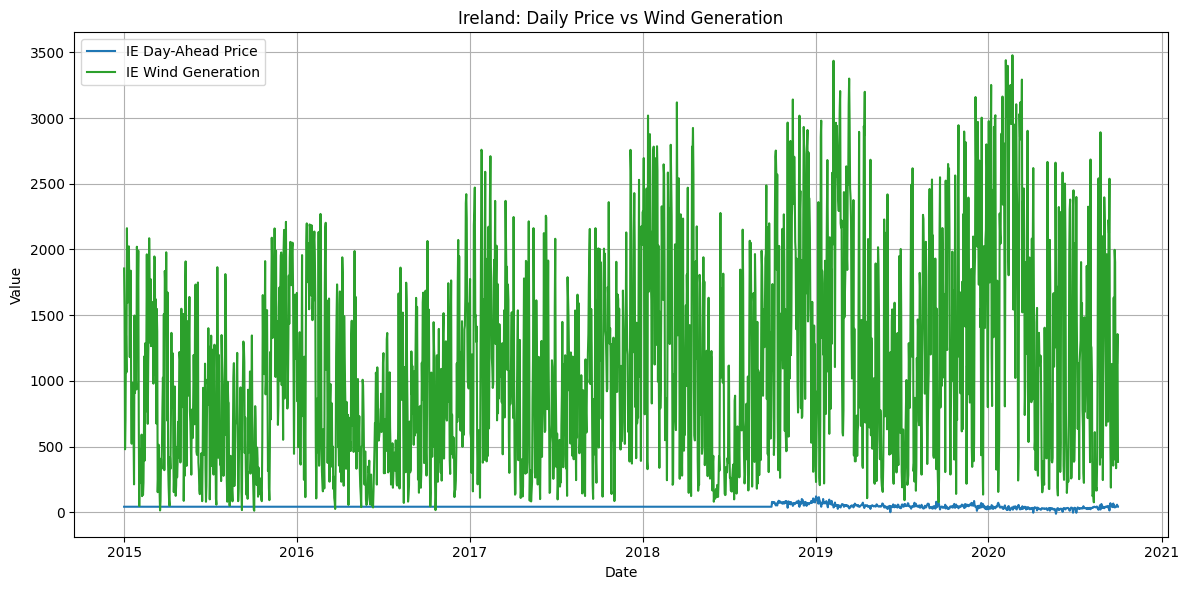

In [ ]:
# An example plot
plt.figure(figsize=(12, 6))

# Play around with these and figure out some meaningful comparisons
# First axis
plt.plot(pdf["date"], pdf["ie_sem_price_day_ahead_daily_avg"], label="IE Day-Ahead Price", color="tab:blue")

# Second axis
plt.plot(pdf["date"], pdf["ie_sem_wind_onshore_generation_actual_daily_avg"], label="IE Wind Generation", color="tab:green")

plt.title("Ireland: Daily Price vs Wind Generation")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()